In [11]:
import warnings
warnings.filterwarnings('ignore')

import awkward as ak
import uproot
import hist
import numpy as np
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

In [13]:
import json

# Open the JSON file for reading
with open('2022/2022_VBF.json', 'r') as file:
    data = json.load(file)

samples = data["VBF_Hto2B"]
sample = samples[1]

In [32]:
sample = 'root://cmsxrootd.fnal.gov//store/mc/Run3Summer22NanoAODv12/VBFHto2B_M-125_dipoleRecoilOn_TuneCP5_13p6TeV_powheg-pythia8/NANOAODSIM/130X_mcRun3_2022_realistic_v5-v2/30000/54dd7983-d56f-4a44-b2b0-c1ede912ff1b.root'
sample_2 = "root://cmsxrootd.fnal.gov//store/mc/Run3Summer22NanoAODv12/VBFHto2B_M-125_dipoleRecoilOn_TuneCP5_13p6TeV_powheg-pythia8/NANOAODSIM/130X_mcRun3_2022_realistic_v5-v2/2530000/e4dbfa25-2fdc-4ced-be09-4dda5879918d.root"

In [3]:
events = NanoEventsFactory.from_root(sample, schemaclass=NanoAODSchema).events()

In [4]:
class TriggerEfficiencyProcessor(processor.ProcessorABC):
    def __init__(self, triggers):
        self.triggers = triggers
        ht_axis = hist.axis.Regular(bins=100, start=0, stop=3000, name="ht", label="H_{T} [GeV]")
        mh_axis = hist.axis.Regular(bins=100, start=0, stop=400, name="mh", label="m_{Jet} [GeV]")

        # Create histograms for each trigger
        self.output = processor.dict_accumulator({
            trigger: {
                'ht_total': hist.Hist(ht_axis),
                'ht_pass': hist.Hist(ht_axis),
                'mh_total': hist.Hist(mh_axis),
                'mh_pass': hist.Hist(mh_axis)
            } for trigger in triggers
        })

    def process(self, events):
        output = self.output.copy()
        has_fatjets = ak.num(events.FatJet) > 0
        ht = ak.sum(events[has_fatjets].FatJet.pt, axis=1)  # Calculate HT
        baseline = ak.any(events[has_fatjets].FatJet.pt > 30, axis=1)  # Baseline selection
        mh = ak.sum(events[has_fatjets].FatJet.mass, axis=1)  # Calculate mass

        # Loop through each trigger
        for trigger in self.triggers:
            trigger_mask = events.HLT[trigger]
            output[trigger]['ht_total'].fill(ht=ht[baseline])
            output[trigger]['ht_pass'].fill(ht=ht[baseline & trigger_mask[has_fatjets]])
            output[trigger]['mh_total'].fill(mh=mh[baseline])  # Ensure mh is properly shaped to match baseline
            output[trigger]['mh_pass'].fill(mh=mh[baseline & trigger_mask[has_fatjets]])

        return output

    def postprocess(self, accumulator):
        return accumulator


In [14]:
class TriggerEfficiencyProcessor(processor.ProcessorABC):
    def __init__(self, triggers):
        self.triggers = triggers
        pt_axis = hist.axis.Regular(bins=100, start=0, stop=3000, name="pt", label="Leading Jet $p_{T}$ [GeV]")
        msd_axis = hist.axis.Regular(bins=100, start=0, stop=400, name="msd", label="Leading Jet $m_{SD}$ [GeV]")

        self.output = processor.dict_accumulator({
            trigger: {
                'pt_total': hist.Hist(pt_axis),
                'pt_pass': hist.Hist(pt_axis),
                'msd_total': hist.Hist(msd_axis),
                'msd_pass': hist.Hist(msd_axis)
            } for trigger in triggers
        })

    def process(self, events):
        output = self.output.copy()
        
        # Ensure there are events with at least one fat jet
        has_fatjets = ak.num(events.FatJet) > 0
        leading_fatjet_pt = events.FatJet[has_fatjets].pt[:, 0]  # Leading jet pT
        leading_fatjet_msd = events.FatJet[has_fatjets].msoftdrop[:, 0] # Leading jet mSD 
        baseline = ak.any(events.FatJet[has_fatjets].pt > 30, axis=1)  

        # Loop through each trigger
        for trigger in self.triggers:
            trigger_mask = events.HLT[trigger]
            output[trigger]['pt_total'].fill(pt=leading_fatjet_pt[baseline])
            output[trigger]['pt_pass'].fill(pt=leading_fatjet_pt[baseline & trigger_mask[has_fatjets]])
            output[trigger]['msd_total'].fill(msd=leading_fatjet_msd[baseline])  
            output[trigger]['msd_pass'].fill(msd=leading_fatjet_msd[baseline & trigger_mask[has_fatjets]])

        return output

    def postprocess(self, accumulator):
        return accumulator


## Set of triggers to look at

In [16]:
# Christina triggers
triggers_cmantill = ['AK8DiPFJet250_250_MassSD50',
     'AK8DiPFJet260_260_MassSD30',
     'AK8PFJet230_SoftDropMass40',
     'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35',
     'AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35',
     'AK8PFJet275_SoftDropMass40_PFAK8ParticleNetBB0p35',
     'AK8PFJet400_SoftDropMass40',
     'AK8PFJet425_SoftDropMass40',
     'PFHT1050',
     'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65']
triggers_set = triggers_cmantill
len(triggers_cmantill)

10

In [5]:
triggers_VBF = [trig[4:-2] for trig in [
    "HLT_QuadPFJet98_83_71_15_DoublePFBTagDeepCSV_1p3_7p7_VBF1_v",
    "HLT_QuadPFJet98_83_71_15_DoublePFBTagDeepCSV_1p3_VBF2_v",
    "HLT_QuadPFJet103_88_75_15_DoublePFBTagDeepCSV_1p3_7p7_VBF1_v",
    "HLT_QuadPFJet103_88_75_15_DoublePFBTagDeepCSV_1p3_VBF2_v",
    "HLT_QuadPFJet105_88_76_15_DoublePFBTagDeepCSV_1p3_7p7_VBF1_v",
    "HLT_QuadPFJet105_88_76_15_DoublePFBTagDeepCSV_1p3_VBF2_v",
    "HLT_QuadPFJet111_90_80_15_DoublePFBTagDeepCSV_1p3_7p7_VBF1_v",
    "HLT_QuadPFJet111_90_80_15_DoublePFBTagDeepCSV_1p3_VBF2_v"]]

In [6]:
triggers_VBF

['QuadPFJet98_83_71_15_DoublePFBTagDeepCSV_1p3_7p7_VBF1',
 'QuadPFJet98_83_71_15_DoublePFBTagDeepCSV_1p3_VBF2',
 'QuadPFJet103_88_75_15_DoublePFBTagDeepCSV_1p3_7p7_VBF1',
 'QuadPFJet103_88_75_15_DoublePFBTagDeepCSV_1p3_VBF2',
 'QuadPFJet105_88_76_15_DoublePFBTagDeepCSV_1p3_7p7_VBF1',
 'QuadPFJet105_88_76_15_DoublePFBTagDeepCSV_1p3_VBF2',
 'QuadPFJet111_90_80_15_DoublePFBTagDeepCSV_1p3_7p7_VBF1',
 'QuadPFJet111_90_80_15_DoublePFBTagDeepCSV_1p3_VBF2']

In [16]:
triggers_pnet = ['QuadPFJet70_50_40_30_PFBTagParticleNet_2BTagSum0p65',
 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65',
 'QuadPFJet70_50_45_35_PFBTagParticleNet_2BTagSum0p65',
 'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35',
 'AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35',
 'AK8PFJet275_SoftDropMass40_PFAK8ParticleNetBB0p35',
 'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetTauTau0p30',
 'AK8PFJet250_SoftDropMass40_PFAK8ParticleNetTauTau0p30',
 'AK8PFJet275_SoftDropMass40_PFAK8ParticleNetTauTau0p30']
triggers_pnet = set(triggers_pnet)
triggers_set = triggers_pnet
len(triggers_pnet)

9

In [17]:
iterative_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema=NanoAODSchema,
    skipbadfiles=True,  # Skip files that fail to open
    savemetrics=True,   # Save metrics to understand where failures occur
)
fileset = {"Dataset" : samples}
out = iterative_run(
    fileset,
    treename="Events",
    processor_instance=TriggerEfficiencyProcessor(triggers_set),
)

Output()

Output()

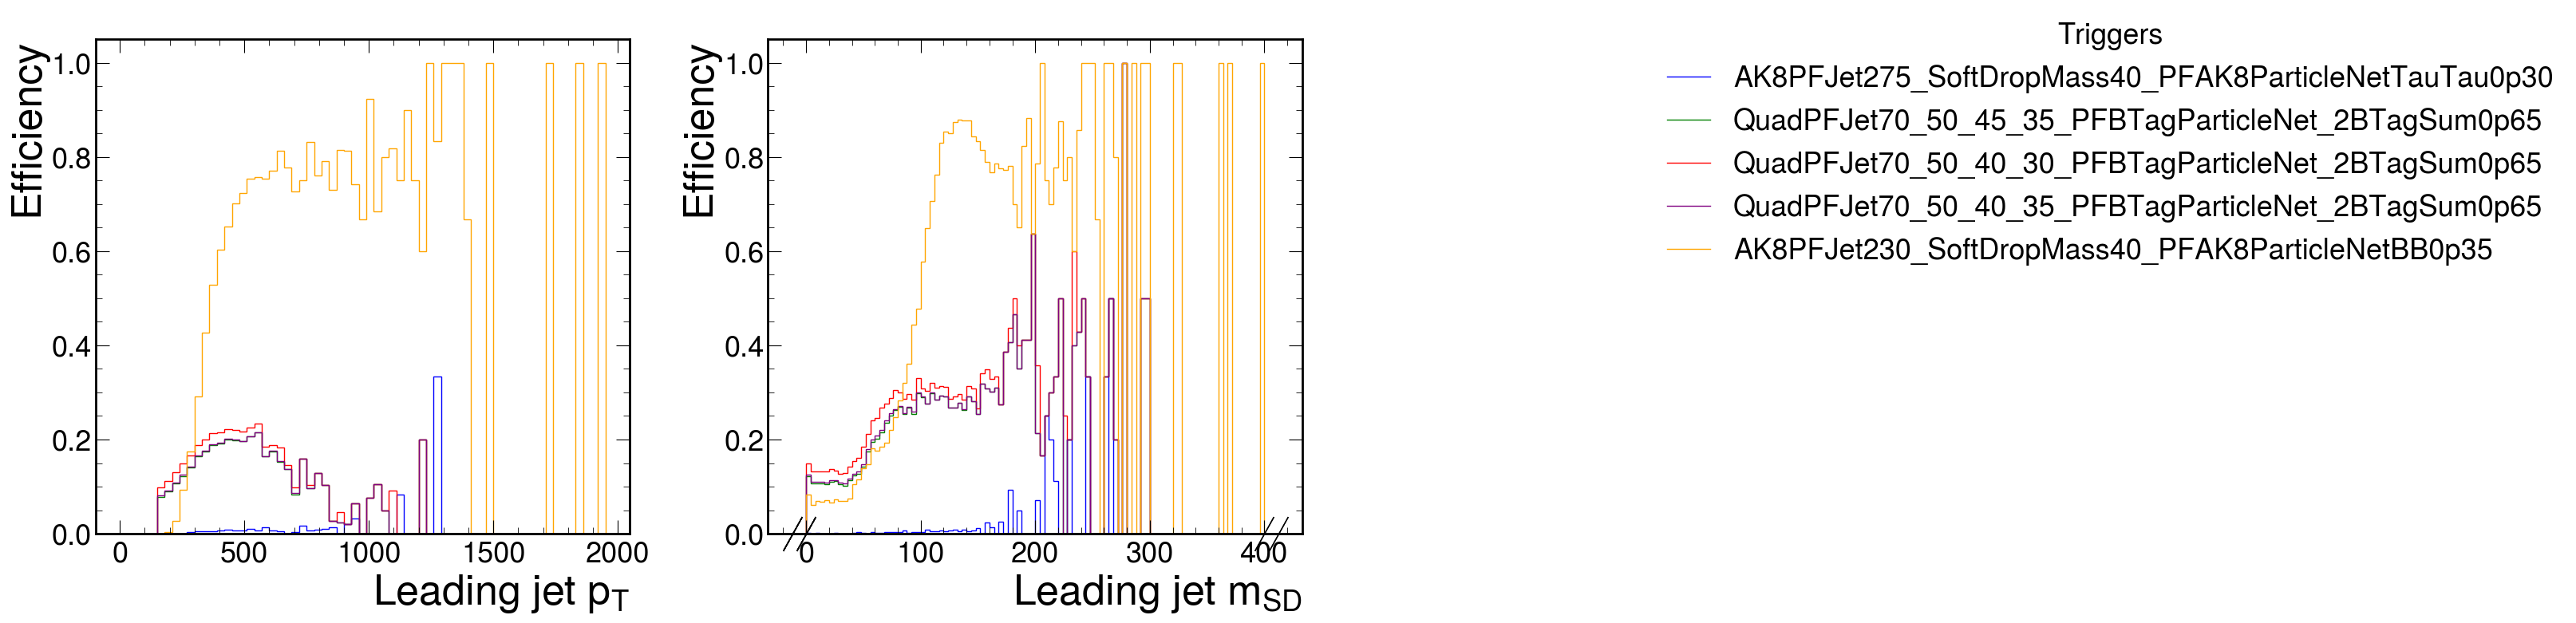

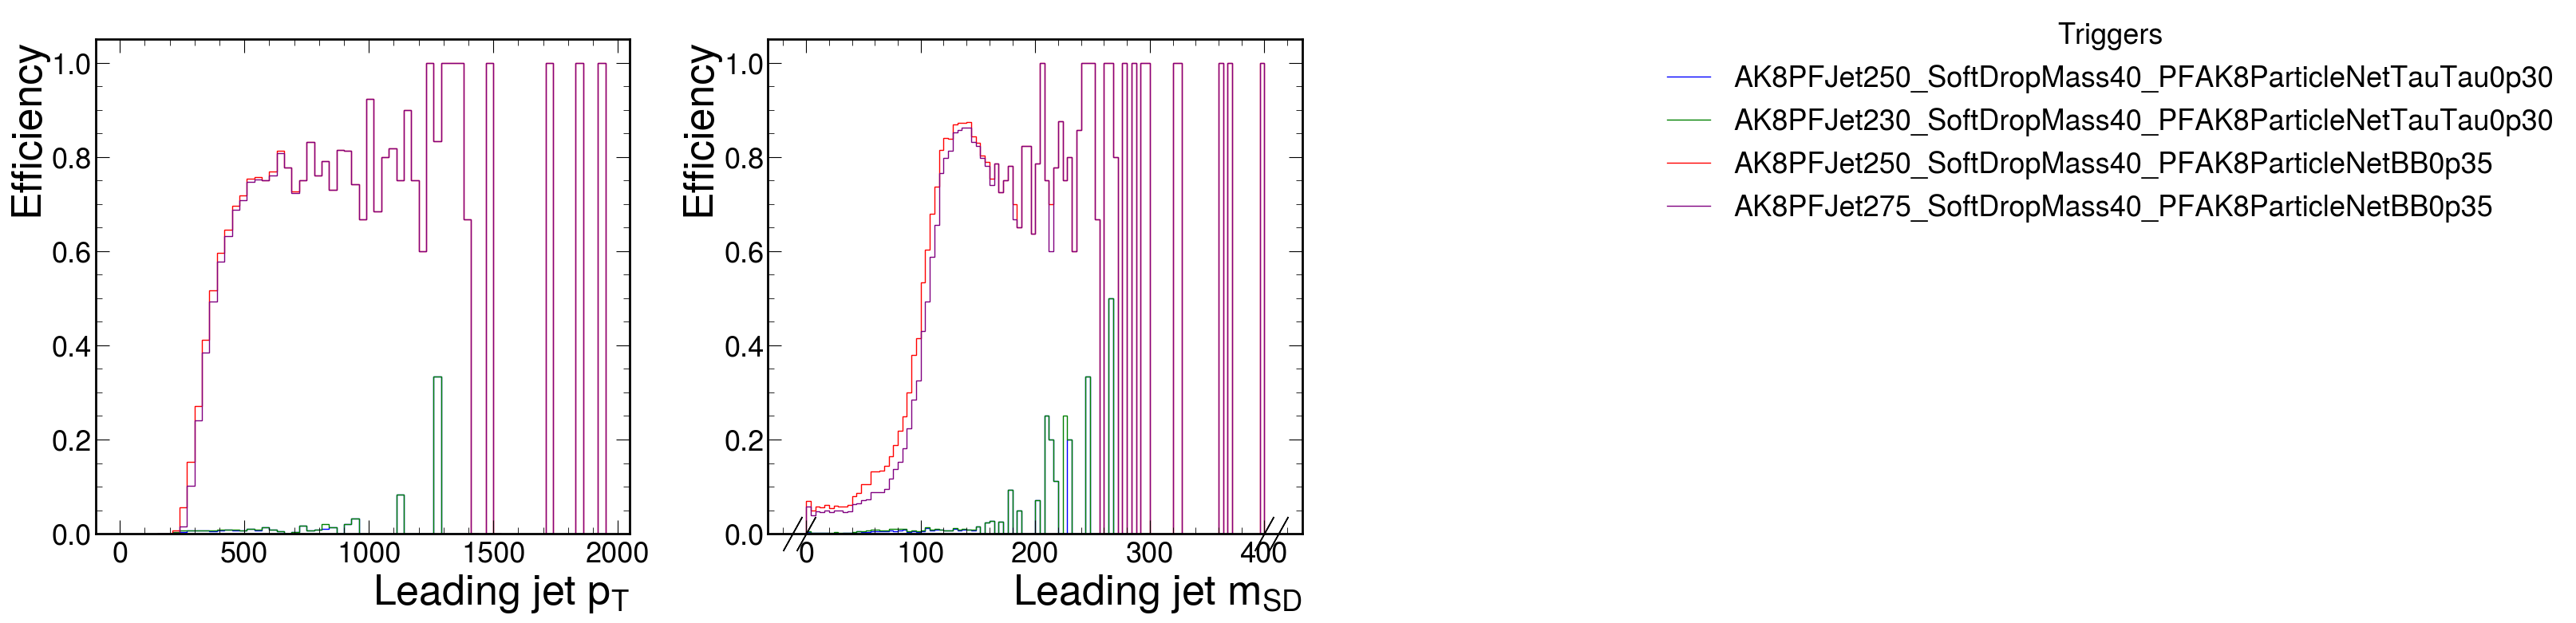

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trigger_efficiencies(trig_name, prod_mode, output, triggers_set, max_triggers_per_plot=5):
    save_dir = f"figures/{prod_mode}/leading_pt_mSD"
    # Function to chunk the triggers_set
    def chunk_triggers(triggers, chunk_size):
        for i in range(0, len(triggers), chunk_size):
            yield triggers[i:i + chunk_size]

    colors = ['blue', 'green', 'red', 'purple', 'orange']  # Adjust or add more colors as needed

    # Chunk the triggers_set into parts of size max_triggers_per_plot
    trigger_chunks = list(chunk_triggers(triggers_set, max_triggers_per_plot))

    for chunk_index, trigger_chunk in enumerate(trigger_chunks):
        fig, axs = plt.subplots(1, 2, figsize=(20, 8))
        
        # First subplot for H_T
        for i, trigger in enumerate(trigger_chunk):
            ht_total = output[trigger]['pt_total']
            ht_pass = output[trigger]['pt_pass']
            efficiency = ht_pass / ht_total
            efficiency.plot(ax=axs[0], label=f'{trigger}', color=colors[i % len(colors)])  # Plot directly on the first subplot

        axs[0].set_xlabel(r'Leading jet $p_T$')
        axs[0].set_ylabel('Efficiency')

        # Second subplot for m_H
        for i, trigger in enumerate(trigger_chunk):
            mh_total = output[trigger]['msd_total']
            mh_pass = output[trigger]['msd_pass']
            efficiency = mh_pass / mh_total
            efficiency.plot(ax=axs[1], label=f'{trigger}', color=colors[i % len(colors)])  # Plot directly on the second subplot

        axs[1].set_xlabel(r'Leading jet $m_{SD}$')
        axs[1].set_ylabel('Efficiency')

        # Place a shared legend outside the plots on the right side
        handles, labels = axs[0].get_legend_handles_labels()  # Only need to extract handles and labels from one axis
        fig.legend(handles, labels, title='Triggers', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

        # Adjust layout to accommodate legends outside of plots
        plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect if needed to fit legend
        plt.savefig(f"{save_dir}/{trig_name}_TriggerEfficiencies_Set{chunk_index + 1}.png", dpi=200, bbox_inches='tight')
        plt.show()

output = out[0]
name = "Cristina"
plot_trigger_efficiencies(name, output, list(triggers_set))


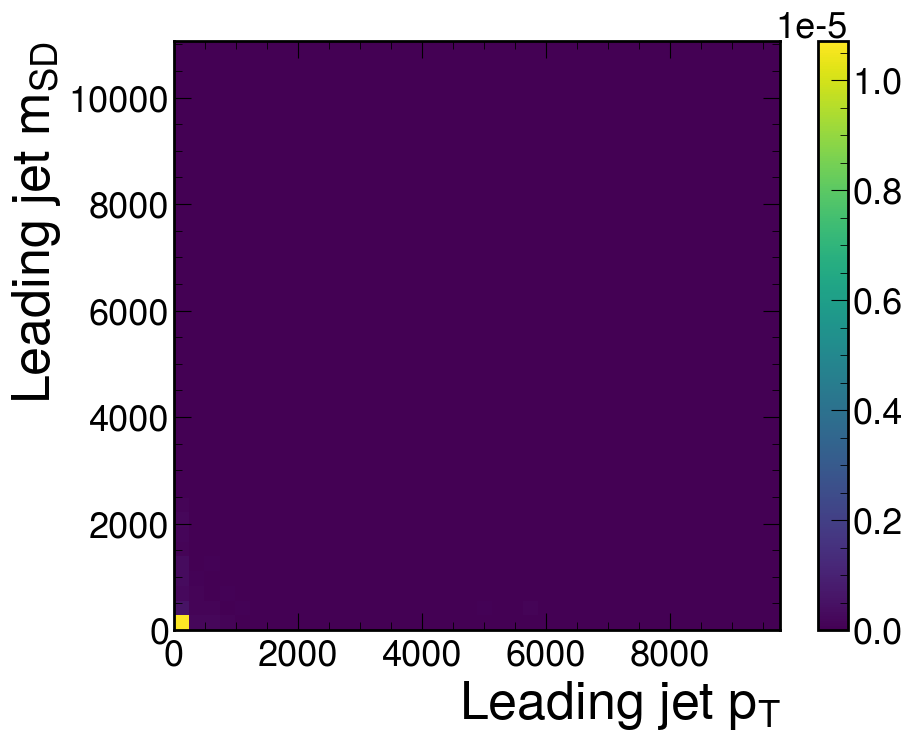

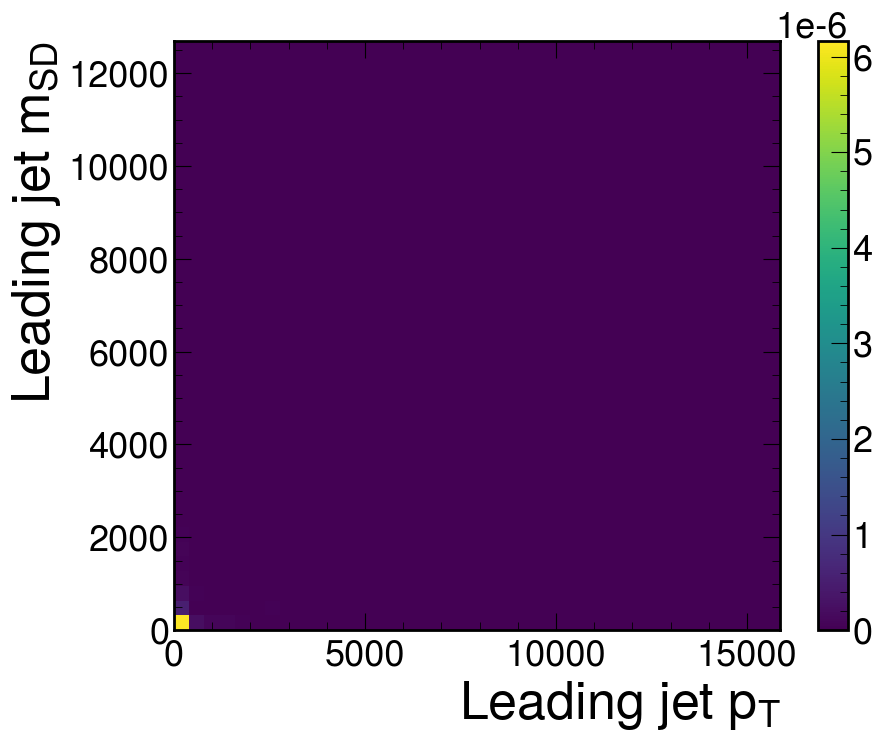

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_2d_trigger_histograms(trig_name, prod_mode, output, triggers_set, max_triggers_per_plot=5):
    save_dir = f"figures/{prod_mode}/leading_pt_mSD"
    
    # Function to chunk the triggers_set
    def chunk_triggers(triggers, chunk_size):
        for i in range(0, len(triggers), chunk_size):
            yield triggers[i:i + chunk_size]

    colors = ['blue', 'green', 'red', 'purple', 'orange']  # Adjust or add more colors as needed

    # Chunk the triggers_set into parts of size max_triggers_per_plot
    trigger_chunks = list(chunk_triggers(triggers_set, max_triggers_per_plot))

    for chunk_index, trigger_chunk in enumerate(trigger_chunks):
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Collect data for all triggers in the chunk
        pts = []
        msds = []
        for trigger in trigger_chunk:
            pts.extend(output[trigger]['pt_pass'])  # Assuming this contains the leading jet p_T values
            msds.extend(output[trigger]['msd_pass'])  # Assuming this contains the leading jet m_{SD} values

        # Create 2D histogram
        h = ax.hist2d(pts, msds, bins=40, range=[[0, 2000], [0, 400]], density=True, cmap='viridis')
        ax.set_xlabel(r'Leading jet $p_T$')
        ax.set_ylabel(r'Leading jet $m_{SD}$')
        # ax.set_title(f'Joint distribution for {trigger_chunk}')
        plt.colorbar(h[3], ax=ax)

        plt.tight_layout()
        plt.show()

output = out[0]
name = "Cristina"
plot_2d_trigger_histograms(name, 'VBF', output, list(triggers_set))
